# Setting up my own pipeline 786

In [20]:
import numpy as np
import torch
import pandas as pd


In [21]:
import sys
sys.path.insert(0, '../')
from core import *
#config
from config import *
#CUDA
cuda=0
device=initCUDA(cuda)
#supporting files




-----------------------------------------------------
Setting device to:  0
Test:  cuda:0
-----------------------------------------------------



## Read Data

In [22]:
# Read just the first row as a DataFrame
df_first = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/F_last")

# If your file has a header row you want to treat as data, keep header=None.
# If it already has column names in row 1 and you want those as column names:
# df_first = pd.read_csv("file.txt", nrows=1)

print(df_first.head())


   1  1.00198  0.000370964  -0.0102491  0.000370964.1  1.00198.1  \
0  2  1.00138     0.000164   -0.006888      -0.000303    1.00194   
1  3  1.00104     0.000081   -0.004466      -0.000219    1.00207   
2  4  1.00089     0.000045   -0.002534      -0.000129    1.00212   
3  5  1.00082     0.000015   -0.000823      -0.000042    1.00214   
4  6  1.00082    -0.000015    0.000823       0.000042    1.00214   

   -0.0102491.1  0.000866093  0.000866093.1  0.994611  
0     -0.010181     0.000096       0.000846  0.995574  
1     -0.010703     0.000090       0.000831  0.995760  
2     -0.011051     0.000034       0.000829  0.995884  
3     -0.011222     0.000012       0.000830  0.995929  
4     -0.011222    -0.000012       0.000830  0.995929  


In [23]:
#Read position
displacement_last = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/displacement_last")

# Drop the first column, then convert to an (N×9) Python list:
displacement =torch.tensor( displacement_last.iloc[1:].to_numpy())   # shape = (N, 9)

displacement.shape

torch.Size([1329, 4])

In [24]:

#Read position
F_last = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/F_last")

# Drop the first column, then convert to an (N×9) Python list:
F_last = torch.tensor(F_last.iloc[:, 1:].to_numpy())   # shape = (N, 9))

# Now `list_9` is a list of N rows, each row itself a list of length 9.
F_last.shape

torch.Size([999, 9])

In [25]:

#Read connectivity
connectivity = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/connectivity")

# Drop the first column, then convert to an (N×9) Python list:
connectivity = connectivity.iloc[:, 1:] # shape = (N, 9))

# Now `list_9` is a list of N rows, each row itself a list of length 9.
connectivity.shape

(999, 8)

In [26]:
connectivity = [torch.tensor(row.tolist(), dtype=torch.long) for _, row in connectivity.iterrows()]
connectivity

[tensor([  9,  10, 514, 513, 117, 118, 604, 603]),
 tensor([ 10,  11, 515, 514, 118, 119, 605, 604]),
 tensor([ 11,  12, 516, 515, 119, 120, 606, 605]),
 tensor([ 12,  13, 517, 516, 120, 121, 607, 606]),
 tensor([ 13,  14, 518, 517, 121, 122, 608, 607]),
 tensor([ 14,  15, 519, 518, 122, 123, 609, 608]),
 tensor([ 15,  16, 520, 519, 123, 124, 610, 609]),
 tensor([ 16,  17, 521, 520, 124, 125, 611, 610]),
 tensor([ 17,   2,  45, 521, 125,  18, 198, 611]),
 tensor([107, 513, 504, 106, 368, 603, 612, 367]),
 tensor([513, 514, 505, 504, 603, 604, 613, 612]),
 tensor([514, 515, 506, 505, 604, 605, 614, 613]),
 tensor([515, 516, 507, 506, 605, 606, 615, 614]),
 tensor([516, 517, 508, 507, 606, 607, 616, 615]),
 tensor([517, 518, 509, 508, 607, 608, 617, 616]),
 tensor([518, 519, 510, 509, 608, 609, 618, 617]),
 tensor([519, 520, 511, 510, 609, 610, 619, 618]),
 tensor([520, 521, 512, 511, 610, 611, 620, 619]),
 tensor([521,  45,  46, 512, 611, 198, 199, 620]),
 tensor([106, 504, 495, 105, 36

In [27]:
#Read volume
vol = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/vol_last")

# Drop the first column, then convert to an (N×9) Python list:
vol = torch.tensor(vol.iloc[:, 1:].to_numpy())   # shape = (N, 9))

vol.shape

torch.Size([999, 1])

In [28]:
#Read volume
position_last = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/position_last")

# Drop the first column, then convert to an (N×9) Python list:
position_last = torch.tensor(position_last.iloc[:, 1:].to_numpy())   # shape = (N, 9))

position_last.shape

torch.Size([1330, 3])

In [29]:
#Read volume
stress_last = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/stress_last")

# Drop the first column, then convert to an (N×9) Python list:
stress_last = torch.tensor(stress_last.iloc[:, 1:].to_numpy())   # shape = (N, 9))

stress_last.shape

torch.Size([999, 6])

In [30]:
import torch

# Suppose `stress_last` has shape [Ne, 6], with columns:
#   [sigma_xx, sigma_yy, sigma_zz, sigma_xy, sigma_yz, sigma_xz]
stress_last = torch.randn(stress_last.shape[0], 6)  # replace with your actual [Ne,6] tensor

# 1) Unpack each Voigt component:
sigma_xx = stress_last[:, 0]    # shape [Ne]
sigma_yy = stress_last[:, 1]    # shape [Ne]
sigma_zz = stress_last[:, 2]    # shape [Ne]
sigma_xy = stress_last[:, 3]    # shape [Ne]
sigma_yz = stress_last[:, 4]    # shape [Ne]
sigma_xz = stress_last[:, 5]    # shape [Ne]

# 2) Create a [Ne,3,3] tensor and fill in symmetric entries:
Ne = stress_last.shape[0]
device = stress_last.device

sigma_full = torch.zeros((Ne, 3, 3), device=device, dtype=stress_last.dtype)

sigma_full[:, 0, 0] = sigma_xx
sigma_full[:, 1, 1] = sigma_yy
sigma_full[:, 2, 2] = sigma_zz

sigma_full[:, 0, 1] = sigma_xy
sigma_full[:, 1, 0] = sigma_xy

sigma_full[:, 1, 2] = sigma_yz
sigma_full[:, 2, 1] = sigma_yz

sigma_full[:, 0, 2] = sigma_xz
sigma_full[:, 2, 0] = sigma_xz

# 3) Finally reshape to [Ne, 9] if you really need a flat 9‐component vector per element:
sigma_flat9 = sigma_full.view(Ne, 9)

# Now sigma_flat9[i] = [sigma_xx, sigma_xy, sigma_xz, sigma_xy, sigma_yy, sigma_yz, sigma_xz, sigma_yz, sigma_zz]
# (i.e. row‐major flatten of the 3×3 tensor).


In [31]:
numNodes=displacement.shape[0]
numElements=F_last.shape[0]
num_nodes_per_element=8
numNodes, numElements

(1329, 999)

### Log file outputs

In [32]:
#Read volume
cx = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_x", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()
cy = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_y", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()
cz=pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_z", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()


# Drop the first column, then convert to an (N×9) Python list:
centroids = torch.tensor(np.stack([cx, cy, cz], axis=1), dtype=torch.float32)[:999]
centroids.requires_grad_(True) 



centroids.shape, centroids


/tmp/ipykernel_8989/1246771159.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cx = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_x", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()
/tmp/ipykernel_8989/1246771159.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cy = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_y", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()
/tmp/ipykernel_8989/1246771159.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cz=pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outp

(torch.Size([999, 3]),
 tensor([[-0.4505, -0.4505,  0.0497],
         [-0.3503, -0.4505,  0.0498],
         [-0.2502, -0.4505,  0.0498],
         ...,
         [ 0.1508,  0.4522,  0.9417],
         [ 0.2513,  0.4522,  0.9417],
         [ 0.3517,  0.4522,  0.9416]], dtype=torch.float32, requires_grad=True))

In [33]:
#This should be for initial tensor of centroids vs last 
#Read volume
cx = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_x", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()
cy = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_y", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()
cz=pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_z", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()


# Drop the first column, then convert to an (N×9) Python list:
centroids_init = torch.tensor(np.stack([cx, cy, cz], axis=1), dtype=torch.float32)[:999]
centroids_init.requires_grad_(True) 



centroids_init.shape, centroids_init


/tmp/ipykernel_8989/3584441370.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cx = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_x", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()
/tmp/ipykernel_8989/3584441370.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cy = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outputs/centroid_y", delim_whitespace=True, header=None, usecols=[1]).squeeze("columns").to_numpy()
/tmp/ipykernel_8989/3584441370.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cz=pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/outp

(torch.Size([999, 3]),
 tensor([[-0.4505, -0.4505,  0.0497],
         [-0.3503, -0.4505,  0.0498],
         [-0.2502, -0.4505,  0.0498],
         ...,
         [ 0.1508,  0.4522,  0.9417],
         [ 0.2513,  0.4522,  0.9417],
         [ 0.3517,  0.4522,  0.9416]], dtype=torch.float32, requires_grad=True))

## Set up architecture of network

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from model import *

model = ICNN3D_position(n_input=6,
                n_hidden=[64,64,64],
                n_output=3,
                use_dropout=True,
                dropout_rate=0.2)

In [19]:
from torchinfo import summary
model = model.to(device)
summary(model)


Layer (type:depth-idx)                   Param #
ICNN3D_position                          --
├─ModuleDict: 1-1                        --
│    └─Linear: 2-1                       448
│    └─convexLinear: 2-2                 4,096
│    └─convexLinear: 2-3                 4,096
│    └─convexLinear: 2-4                 192
├─ModuleDict: 1-2                        --
│    └─Linear: 2-5                       448
│    └─Linear: 2-6                       448
│    └─convexLinear: 2-7                 18
Total params: 9,746
Trainable params: 9,746
Non-trainable params: 0

### Test Function prediction

$$
\int_{\Omega} \boldsymbol{\sigma} : \nabla \mathbf{v} \; d x
\;=\;
\int_{\Omega} \mathbf{f} \cdot \mathbf{v} \; d x
\;+\;
\int_{\partial \Omega} \mathbf{T} \cdot \mathbf{v} \; d s\,.
$$

But if there are no body forces:

$$
a(u,v) \;=\; \int_{\Omega} \sigma(u) : \nabla v \,\mathrm{d}x
$$


$$
L(v) \;=\;  \int_{\partial\Omega} T \cdot v \,\mathrm{d}s
$$

We can then do a minimization of L and a. 

In [112]:
stress_last.shape, stress_last[:,0:1].shape, stress_last[:,0:4].shape, F_last.shape

(torch.Size([999, 6]),
 torch.Size([999, 1]),
 torch.Size([999, 4]),
 torch.Size([999, 9]))

In [15]:
import torch
import torch.nn as nn

class VirtualFieldNet(nn.Module):
    def __init__(self):
        super().__init__()
        # A few hidden layers; output dimension = 3 (virtual displacement components)
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )
    def forward(self, xyz):
        # xyz: [nPoints, 3]
        return self.net(xyz)  # returns [nPoints, 3]
    
v_model = VirtualFieldNet()


In [16]:
print("centroids.dtype =", centroids.dtype)
for name, param in v_model.named_parameters():
    print(f"{name}.dtype =", param.dtype)
    break   # just need one parameter to check


centroids.dtype = torch.float32
net.0.weight.dtype = torch.float64


In [32]:
centroids.shape, F_last.shape, torch.cat((centroids, F_last), dim=1).shape

(torch.Size([999, 3]), torch.Size([999, 9]), torch.Size([999, 12]))

In [20]:
centroids.requires_grad_(True) 
x_input= torch.cat((centroids.to(device), F_last.to(device)), dim=1)

In [21]:
V_NN=model(x_input)
V_NN.shape

torch.Size([999, 3])

In [32]:
grad_outputs = torch.ones_like(V_NN[:, 1])  # shape = [N]

dVx_dcentroids = torch.autograd.grad(
    outputs=V_NN[:, 0],    # shape [N]
    inputs=centroids,      # shape [N,3]
    grad_outputs=grad_outputs,
    create_graph=True
)[0]  # → shape [N,3]

dVy_dcentroids = torch.autograd.grad(
    outputs=V_NN[:, 1],    # shape [N]
    inputs=centroids,      # shape [N,3]
    grad_outputs=grad_outputs,
    create_graph=True
)[0]  # → shape [N,3]

dVz_dcentroids = torch.autograd.grad(
    outputs=V_NN[:, 2],    # shape [N]
    inputs=centroids,      # shape [N,3]
    grad_outputs=grad_outputs,
    create_graph=True
)[0]  # → shape [N,3]

In [33]:
# Stack them into grad_v[e, i, j] = ∂v_i/∂x_j:
grad_v = torch.stack(
    [dVx_dcentroids,    # [N,3] → (i=0)
     dVy_dcentroids,    # [N,3] → (i=1)
     dVz_dcentroids],   # [N,3] → (i=2)
    dim=1               # new dim = “i”
)                      # → grad_v.shape = [N, 3, 3]

$$
a(u,v) \;=\; \int_{\Omega} \sigma(u) : \nabla v \,\mathrm{d}x
$$



In [35]:
# element‐wise inner product σ^e : ∇v^e
integrand = torch.sum(sigma_full * grad_v, dim=(1, 2))  # → shape [N]

a_uv = torch.sum(integrand * vol)  # scalar

$$
L(v) \;=\;  \int_{\partial\Omega} T \cdot v \,\mathrm{d}s
$$

In [41]:
# 3) Build the traction vector T_surf = [0, 0, -1000] for each boundary element:
T_surf = torch.tensor([0.0, 0.0, -1000.0], device=centroids.device)  # [3]
T_surf = T_surf.view(1,3).expand(numElements, 3)  # → [nB, 3]

L_uv=torch.sum(T_surf*V_NN*0.01)

In [42]:
a_uv, L_uv, (T_surf*V_NN).shape

(tensor(4892884.4903, grad_fn=<SumBackward0>),
 tensor(-19804954.0409, grad_fn=<SumBackward0>),
 torch.Size([999, 3]))

In [52]:
epoch=250
# Adam with a learning rate:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in range(epoch):
    optimizer.zero_grad()              # ← reset gradients

    #Estimate
    V_NN=model(x_input)
    
    #Gradients
    grad_outputs = torch.ones_like(V_NN[:, 1])  # shape = [N]

    dVx_dcentroids = torch.autograd.grad(
        outputs=V_NN[:, 0],    # shape [N]
        inputs=centroids,      # shape [N,3]
        grad_outputs=grad_outputs,
        create_graph=True
    )[0]  # → shape [N,3]

    dVy_dcentroids = torch.autograd.grad(
        outputs=V_NN[:, 1],    # shape [N]
        inputs=centroids,      # shape [N,3]
        grad_outputs=grad_outputs,
        create_graph=True
    )[0]  # → shape [N,3]

    dVz_dcentroids = torch.autograd.grad(
        outputs=V_NN[:, 2],    # shape [N]
        inputs=centroids,      # shape [N,3]
        grad_outputs=grad_outputs,
        create_graph=True
    )[0]  # → shape [N,3]

    # Stack them into grad_v[e, i, j] = ∂v_i/∂x_j:
    grad_v = torch.stack(
        [dVx_dcentroids,    # [N,3] → (i=0)
        dVy_dcentroids,    # [N,3] → (i=1)
        dVz_dcentroids],   # [N,3] → (i=2)
        dim=1               # new dim = “i”
    )                      # → grad_v.shape = [N, 3, 3]

    #Strain

    virtual_strain=0.5*(grad_v+grad_v.transpose(1,2))

    #Volume integral:
    # element‐wise inner product σ^e : ∇v^e
    integrand = torch.sum(sigma_full * virtual_strain, dim=(1, 2))  # → shape [N]

    a_uv = torch.sum(integrand * vol)  # scalar

    #Surface integral:

    # 3) Build the traction vector T_surf = [0, 0, -1000] for each boundary element:
    T_surf = torch.tensor([0.0, 0.0, -1000.0], device=centroids.device)  # [3]
    T_surf = T_surf.view(1,3).expand(numElements, 3)  # → [nB, 3]

    L_uv=torch.sum(T_surf*V_NN*0.01)

    #Loss:
    loss=a_uv-L_uv

    if i%10==0:
        print(f'Epoch {i} loss: {loss.item()}')

    loss.backward()

    optimizer.step()

Epoch 0 loss: 62781.804830020774
Epoch 10 loss: 61572.57047346433
Epoch 20 loss: 60065.0341208992
Epoch 30 loss: 59397.67381849515
Epoch 40 loss: 58536.34007410749
Epoch 50 loss: 57927.439788430784
Epoch 60 loss: 57301.63448869555
Epoch 70 loss: 56693.291529924056
Epoch 80 loss: 56088.877988833694
Epoch 90 loss: 55518.76007202036
Epoch 100 loss: 54929.48588471265
Epoch 110 loss: 54375.94205487245
Epoch 120 loss: 53817.846766437695
Epoch 130 loss: 53261.29409532341
Epoch 140 loss: 52737.198514484626
Epoch 150 loss: 52203.43886304635
Epoch 160 loss: 51677.57725026529
Epoch 170 loss: 51158.47647103532
Epoch 180 loss: 50644.37489158097
Epoch 190 loss: 50134.29068573398
Epoch 200 loss: 49629.10054354105
Epoch 210 loss: 49135.40051075414
Epoch 220 loss: 48642.80322594891
Epoch 230 loss: 48165.191242840716
Epoch 240 loss: 47680.98168491004


In [51]:
V_NN.shape

torch.Size([999, 3])

## Incorporate Taylor Expansions

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from model import *

model = ICNN3D_global_Taylor(n_input=6,
                n_hidden=[64,64,64],
                n_output=30,
                use_dropout=True,
                dropout_rate=0.2)

In [35]:
from torchinfo import summary
model = model.to(device)
summary(model)

Layer (type:depth-idx)                   Param #
ICNN3D_global_Taylor                     --
├─ModuleDict: 1-1                        --
│    └─Linear: 2-1                       448
│    └─convexLinear: 2-2                 4,096
│    └─convexLinear: 2-3                 4,096
│    └─convexLinear: 2-4                 1,920
├─ModuleDict: 1-2                        --
│    └─Linear: 2-5                       448
│    └─Linear: 2-6                       448
│    └─convexLinear: 2-7                 180
├─AdaptiveAvgPool1d: 1-3                 --
Total params: 11,636
Trainable params: 11,636
Non-trainable params: 0

In [36]:
x_input= torch.cat(( F_last.to(device),centroids.to(device)), dim=1)
dx = -centroids_init[:, 0] + centroids[:, 0]
dy = -centroids_init[:, 1] + centroids[:, 1]
dz = -centroids_init[:, 2] + centroids[:, 2]


In [37]:
V_NN=model(x_input) #This is N elements x9 

In [38]:
V_NN.shape

torch.Size([30, 1])

In [39]:
epoch=250
# Adam with a learning rate:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in range(epoch):
    optimizer.zero_grad()              # ← reset gradients

    #Estimate
    V_NN=model(x_input) #This is N elements x9 
    
    #Construct VF 
    #Vx=V_NN[:,0]+V_NN[:,1]*(centroids_init[:,0]-centroids[:,0])+V_NN[:,2]*(centroids_init[:,0]-centroids[:,0])**2
    #Vy=V_NN[:,3]+V_NN[:,4]*(centroids_init[:,0]-centroids[:,0])+V_NN[:,5]*(centroids_init[:,0]-centroids[:,0])**2
   # Vz=V_NN[:,6]+V_NN[:,7]*(centroids_init[:,0]-centroids[:,0])+V_NN[:,8]*(centroids_init[:,0]-centroids[:,0])**2
# Vx uses indices 0..9
    a = V_NN[0:10]   # (Nelements,10)
    # expand into the 10 monomials:
    Vx = (
        a[0]
        + a[1] * dx
        + a[2] * dy
        + a[3] * dz
        + a[4] * dx**2
        + a[5] * dy**2
        + a[6] * dz**2
        + a[7] * (dx * dy)
        + a[8] * (dx * dz)
        + a[9] * (dy * dz)
    )

    # Vy uses indices 10..19
    b = V_NN[10:20]  # (Nelements,10)
    Vy = (
        b[0]
        + b[1] * dx
        + b[2] * dy
        + b[3] * dz
        + b[4] * dx**2
        + b[5] * dy**2
        + b[6] * dz**2
        + b[7] * (dx * dy)
        + b[8] * (dx * dz)
        + b[9] * (dy * dz)
    )

    # Vz uses indices 20..29
    c = V_NN[20:30]  # (Nelements,10)
    Vz = (
        c[0]
        + c[1] * dx
        + c[2] * dy
        + c[3] * dz
        + c[4] * dx**2
        + c[5] * dy**2
        + c[6] * dz**2
        + c[7] * (dx * dy)
        + c[8] * (dx * dz)
        + c[9] * (dy * dz)
    )

    VF=torch.cat((Vx.unsqueeze(1),Vy.unsqueeze(1),Vz.unsqueeze(1)), dim=1)

    #Gradients

    # --- 0) Assume we already defined dx, dy, dz as (Nelements,) tensors ---

    # 1) Split the network output into three 10‐column blocks:
    a = V_NN[  0:10]   # (Nelements, 10)  → a[:,0..9] = (a0..a9) for Vx
    b = V_NN[ 10:20]   # (Nelements, 10)  → b[:,0..9] = (b0..b9) for Vy
    c = V_NN[ 20:30]   # (Nelements, 10)  → c[:,0..9] = (c0..c9) for Vz

    # 2) For readability, pull out each “coefficient” as a 1D tensor of shape (Nelements,)
    #    (You can also vectorize directly from the slices, but naming them clarifies the math.)
    a0 = a[ 0];  a1 = a[ 1];  a2 = a[ 2];  a3 = a[ 3]
    a4 = a[ 4];  a5 = a[ 5];  a6 = a[ 6];  a7 = a[ 7]
    a8 = a[ 8];  a9 = a[ 9]

    b0 = b[ 0];  b1 = b[ 1];  b2 = b[ 2];  b3 = b[ 3]
    b4 = b[ 4];  b5 = b[ 5];  b6 = b[ 6];  b7 = b[ 7]
    b8 = b[ 8];  b9 = b[ 9]

    c0 = c[ 0];  c1 = c[ 1];  c2 = c[ 2];  c3 = c[ 3]
    c4 = c[ 4];  c5 = c[ 5];  c6 = c[ 6];  c7 = c[ 7]
    c8 = c[ 8];  c9 = c[ 9]

    # 3) Build each partial derivative as a 1D tensor of shape (Nelements,)

    # -- ∂Vx/∂x, ∂Vx/∂y, ∂Vx/∂z --
    dVx_dx = (
        - a1
        - 2.0 * a4 * dx
        -       a7 * dy
        -       a8 * dz
    )   # shape (Nelements,)

    dVx_dy = (
        - a2
        - 2.0 * a5 * dy
        -       a7 * dx
        -       a9 * dz
    )   # shape (Nelements,)

    dVx_dz = (
        - a3
        - 2.0 * a6 * dz
        -       a8 * dx
        -       a9 * dy
    )   # shape (Nelements,)

    # -- ∂Vy/∂x, ∂Vy/∂y, ∂Vy/∂z --
    dVy_dx = (
        - b1
        - 2.0 * b4 * dx
        -       b7 * dy
        -       b8 * dz
    )   # shape (Nelements,)

    dVy_dy = (
        - b2
        - 2.0 * b5 * dy
        -       b7 * dx
        -       b9 * dz
    )   # shape (Nelements,)

    dVy_dz = (
        - b3
        - 2.0 * b6 * dz
        -       b8 * dx
        -       b9 * dy
    )   # shape (Nelements,)

    # -- ∂Vz/∂x, ∂Vz/∂y, ∂Vz/∂z --
    dVz_dx = (
        - c1
        - 2.0 * c4 * dx
        -       c7 * dy
        -       c8 * dz
    )   # shape (Nelements,)

    dVz_dy = (
        - c2
        - 2.0 * c5 * dy
        -       c7 * dx
        -       c9 * dz
    )   # shape (Nelements,)

    dVz_dz = (
        - c3
        - 2.0 * c6 * dz
        -       c8 * dx
        -       c9 * dy
    )   # shape (Nelements,)


    # Stack them into grad_v[e, i, j] = ∂v_i/∂x_j:
    # Stack them row‐by‐row
    row1 = torch.stack((dVx_dx, dVx_dy, dVx_dz), dim=1)   # → (Nelements, 3)
    row2 = torch.stack((dVy_dx, dVy_dy, dVy_dz), dim=1)   # → (Nelements, 3)
    row3 = torch.stack((dVz_dx, dVz_dy, dVz_dz), dim=1)   # → (Nelements, 3)

    # Now stack those three rows into a (3×3) block, for each element:
    # shape (Nelements, 3, 3)
    grad_V = torch.stack((row1, row2, row3), dim=1)

    #Strain

    virtual_strain=0.5*(grad_V+grad_V.transpose(1,2))

    #Volume integral:
    # element‐wise inner product σ^e : ∇v^e
    integrand = torch.sum(sigma_full * virtual_strain, dim=(1, 2))  # → shape [N]

    a_uv = torch.sum(integrand * vol)  # scalar

    #Surface integral:

    # 3) Build the traction vector T_surf = [0, 0, -1000] for each boundary element:
    T_surf = torch.tensor([0.0, 0.0, -1000.0], device=centroids.device)  # [3]
    T_surf = T_surf.view(1,3).expand(numElements, 3)  # → [nB, 3]

    L_uv=torch.sum(T_surf*VF*0.01)

    #Loss:
    loss=a_uv-L_uv

    if i%10==0:
        print(f'Epoch {i} loss: {loss.item()}')

    loss.backward()

    optimizer.step()

Epoch 0 loss: 25596.986175587994
Epoch 10 loss: 22851.70380687727
Epoch 20 loss: 21897.439324464747
Epoch 30 loss: 21246.130431901347
Epoch 40 loss: 20728.144189467002
Epoch 50 loss: 20282.349315356343
Epoch 60 loss: 19775.012234173842
Epoch 70 loss: 19238.017029694103
Epoch 80 loss: 18853.71990388989
Epoch 90 loss: 18394.236579438777
Epoch 100 loss: 18019.58379446018
Epoch 110 loss: 17590.384317745265
Epoch 120 loss: 17216.961147379705
Epoch 130 loss: 16888.336427719747
Epoch 140 loss: 16466.049895997625
Epoch 150 loss: 16177.353652700609
Epoch 160 loss: 15784.089907000363
Epoch 170 loss: 15483.622458626864
Epoch 180 loss: 15205.931147995976
Epoch 190 loss: 14908.645753994984
Epoch 200 loss: 14604.908330529339
Epoch 210 loss: 14286.797843341405
Epoch 220 loss: 14019.258631234568
Epoch 230 loss: 13794.921953510286
Epoch 240 loss: 13497.468375554387


In [40]:
VF.shape

torch.Size([999, 3])

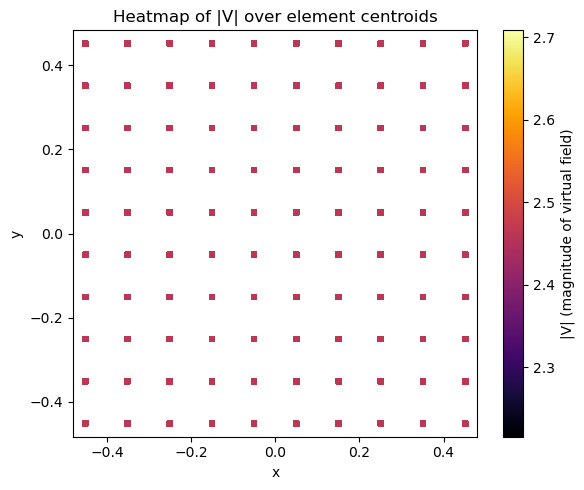

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ── (Assume these are already in your workspace) ──
# centroids:  (Nelements, 3) torch.Tensor [x_i, y_i, z_i]
# VF:         (Nelements, 3) torch.Tensor [Vx_i, Vy_i, Vz_i]

# 1) Convert to NumPy (if they’re still PyTorch tensors)
centroids_np = centroids.detach().cpu().numpy()  # (Nelements, 3)
VF_np        = VF.detach().cpu().numpy()         # (Nelements, 3)

# 2) Extract x, y, and compute magnitude
x = centroids_np[:, 0]      # (Nelements,)
y = centroids_np[:, 1]      # (Nelements,)

# magnitude of the 3‐D virtual field vector at each centroid:
mag = np.sqrt((VF_np**2).sum(axis=1))  # (Nelements,)

# 3) Make a scatter “heatmap” on the xy‐plane, colored by |V|
plt.figure(figsize=(6,5))
sc = plt.scatter(
    x, 
    y, 
    c=mag, 
    cmap="inferno",     # you can choose "viridis", "plasma", etc.
    s=20,               # marker size: tweak if too big/small
    marker="s",         # square markers often look more heatmap‐like
    edgecolors="none"
)
plt.colorbar(sc, label="|V| (magnitude of virtual field)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Heatmap of |V| over element centroids")
plt.axis("equal")       # ensures x- and y-scales match
plt.tight_layout()
plt.show()


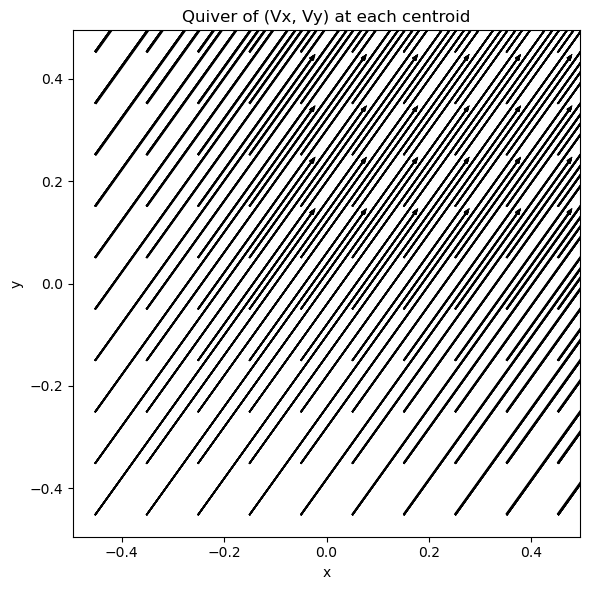

In [62]:
from mpl_toolkits.mplot3d import Axes3D
# 1) Convert to NumPy for easy printing:
VF_np         = VF.detach().cpu().numpy()          # shape = (Nelements, 3)
centroids_np  = centroids.detach().cpu().numpy()   # shape = (Nelements, 3)


import matplotlib.pyplot as plt

# 1) Convert to NumPy:
VF_np        = VF.detach().cpu().numpy()       # (Nelements, 3)
centroids_np = centroids.detach().cpu().numpy()# (Nelements, 3)

x = centroids_np[:, 0]   # (Nelements,)
y = centroids_np[:, 1]   # (Nelements,)
u = VF_np[:, 0]          # Vx at each centroid
v = VF_np[:, 1]          # Vy at each centroid

plt.figure(figsize=(6,6))
plt.quiver(
    x, y,       # arrow‐base positions
    u, v,       # arrow components
    angles="xy", scale_units="xy", scale=1.0,
    width=0.003, headwidth=3, headlength=4
)
plt.axis("equal")    # so that 1 unit in x = 1 unit in y
plt.xlabel("x")
plt.ylabel("y")
plt.title("Quiver of (Vx, Vy) at each centroid")
plt.tight_layout()
plt.show()



epoch=250
# Adam with a learning rate:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in range(epoch):
    optimizer.zero_grad()              # ← reset gradients

    #Estimate
    V_NN=model(x_input) #This is N elements x9 
    
    #Construct VF 
    #Vx=V_NN[:,0]+V_NN[:,1]*(centroids_init[:,0]-centroids[:,0])+V_NN[:,2]*(centroids_init[:,0]-centroids[:,0])**2
    #Vy=V_NN[:,3]+V_NN[:,4]*(centroids_init[:,0]-centroids[:,0])+V_NN[:,5]*(centroids_init[:,0]-centroids[:,0])**2
   # Vz=V_NN[:,6]+V_NN[:,7]*(centroids_init[:,0]-centroids[:,0])+V_NN[:,8]*(centroids_init[:,0]-centroids[:,0])**2
# Vx uses indices 0..9
    a = V_NN[0:10]   # (Nelements,10)
    # expand into the 10 monomials:
    Vx = (
        a[0]
        + a[1] * dx
        + a[2] * dy
        + a[3] * dz
        + a[4] * dx**2
        + a[5] * dy**2
        + a[6] * dz**2
        + a[7] * (dx * dy)
        + a[8] * (dx * dz)
        + a[9] * (dy * dz)
    )

    # Vy uses indices 10..19
    b = V_NN[10:20]  # (Nelements,10)
    Vy = (
        b[0]
        + b[1] * dx
        + b[2] * dy
        + b[3] * dz
        + b[4] * dx**2
        + b[5] * dy**2
        + b[6] * dz**2
        + b[7] * (dx * dy)
        + b[8] * (dx * dz)
        + b[9] * (dy * dz)
    )

    # Vz uses indices 20..29
    c = V_NN[20:30]  # (Nelements,10)
    Vz = (
        c[0]
        + c[1] * dx
        + c[2] * dy
        + c[3] * dz
        + c[4] * dx**2
        + c[5] * dy**2
        + c[6] * dz**2
        + c[7] * (dx * dy)
        + c[8] * (dx * dz)
        + c[9] * (dy * dz)
    )

    VF=torch.cat((Vx.unsqueeze(1),Vy.unsqueeze(1),Vz.unsqueeze(1)), dim=1)

    #Gradients
    grad_outputs = torch.ones_like(V_NN[:, 1])  # shape = [N]

    dVx_dcentroids = torch.autograd.grad(
        outputs=Vx,    # shape [N]
        inputs=centroids,      # shape [N,3]
        grad_outputs=grad_outputs,
        create_graph=True
    )[0]  # → shape [N,3]

    dVy_dcentroids = torch.autograd.grad(
        outputs=Vy,    # shape [N]
        inputs=centroids,      # shape [N,3]
        grad_outputs=grad_outputs,
        create_graph=True
    )[0]  # → shape [N,3]

    dVz_dcentroids = torch.autograd.grad(
        outputs=Vz,    # shape [N]
        inputs=centroids,      # shape [N,3]
        grad_outputs=grad_outputs,
        create_graph=True
    )[0]  # → shape [N,3]

    # Stack them into grad_v[e, i, j] = ∂v_i/∂x_j:
    grad_v = torch.stack(
        [dVx_dcentroids,    # [N,3] → (i=0)
        dVy_dcentroids,    # [N,3] → (i=1)
        dVz_dcentroids],   # [N,3] → (i=2)
        dim=1               # new dim = “i”
    )                      # → grad_v.shape = [N, 3, 3]

    #Strain

    virtual_strain=0.5*(grad_v+grad_v.transpose(1,2))

    #Volume integral:
    # element‐wise inner product σ^e : ∇v^e
    integrand = torch.sum(sigma_full * virtual_strain, dim=(1, 2))  # → shape [N]

    a_uv = torch.sum(integrand * vol)  # scalar

    #Surface integral:

    # 3) Build the traction vector T_surf = [0, 0, -1000] for each boundary element:
    T_surf = torch.tensor([0.0, 0.0, -1000.0], device=centroids.device)  # [3]
    T_surf = T_surf.view(1,3).expand(numElements, 3)  # → [nB, 3]

    L_uv=torch.sum(T_surf*VF*0.01)

    #Loss:
    loss=a_uv-L_uv

    if i%10==0:
        print(f'Epoch {i} loss: {loss.item()}')

    loss.backward()

    optimizer.step()

## Virtual Fields

In [ ]:
#Need to revise the 1000 vs 99
v_x_star1 = torch.zeros_like(centroids[:-1,0]) 
v_y_star1 = torch.zeros_like(centroids[:-1,0]) 
v_z_star1 = -centroids[:-1,2]


virtual_displacement1 = torch.stack([v_x_star1, v_y_star1, v_z_star1], dim=1)  #torch.Size([Nodes, 2])

zeros = torch.zeros_like(v_z_star1)
minus_ones = -torch.ones_like(v_z_star1)

gradient_virtual_displacement = torch.stack([
    zeros, zeros, zeros,  # ∂v_x/∂x, ∂v_x/∂y, ∂v_x/∂z
    zeros, zeros, zeros,  # ∂v_y/∂x, ∂v_y/∂y, ∂v_y/∂z
    zeros, zeros, minus_ones  # ∂v_z/∂x, ∂v_z/∂y, ∂v_z/∂z
], dim=1)  #shape: [Nodes, 9]

In [81]:
gradient_virtual_displacement.shape

torch.Size([999, 9])

## Internal Virtual Work

$$
\text{IVW}_k(\mathcal{Q}, \mathbf{v}^*) 
= V_k \, \xi^{*k}_{ij} \, \sigma^k_{ij}(\mathcal{Q}) 
= V_k \, \xi^{*k}_{ij} \left( \frac{1}{J_k} P^k_{im} F^k_{jm} \right)
$$
Where:
* k is each element

In [56]:
F_mat = torch.stack([
    torch.stack([F_last[:,0:1], F_last[:,1:2],F_last[:,2:3]], dim=-1),
    torch.stack([F_last[:,3:4], F_last[:,4:5],F_last[:,5:6]], dim=-1),
    torch.stack([F_last[:,6:7], F_last[:,7:8],F_last[:,8:9]], dim=-1)
], dim=-2).squeeze() #torch.Size([2752, 2, 2]) after squeeze 
P_mat=torch.zeros_like(F_mat)
J = torch.det(F_mat)         # [nElem]
F_mat.shape

torch.Size([999, 3, 3])

In [90]:
sigma = (P_mat @ F_mat.transpose(-2,-1)) / J.view(-1,1,1) # [nElem,2,2]


# --- flatten σᵢⱼ in the standard row‐major order [11,12,21,22] ---
sigma_flat = sigma.view(-1,9)   # [nElem,9]	
F_mat_flat = F_mat.view(-1,9)   # [nElem,9]	
P_mat_flat = P_mat.view(-1,9)   # [nElem,9]	

In [97]:
# Calculate element IVF

element_internal_IVF=vol.squeeze()*torch.sum(gradient_virtual_displacement*sigma_flat,dim=1)

element_internal_IVF.shape

torch.Size([999])

In [99]:
total_IVF=torch.sum(element_internal_IVF)
total_IVF

tensor(0.)

### External Virtual Field

$$
\mathrm{EVW}_k\bigl(\mathbf{v}^*\bigr) \;=\; S^k \, v^{*k}_{i} \, \tau_i^k
$$


In [ ]:
#Calculate element EVF


In [ ]:
 #connectivity is a list of 3 1D-matrix. Each matrix contains integers.
#Length of each matrix is equal to numElements. 
#For 2D-triangular elements with a={0,1,2}:
#connectivity[a][e]: is the index of the 'a'-th node of the 'e'-th element.
#Note that node indices range from 0 to (numNodes-1).
# # Mapping from **elements to nodes**
#f_int_nodes[:,i].index_add_(0,data.connectivity[a],force)
#ewk[:,i].index_add_(0,data.connectivity[a],external_virtual_work)

#From elements to nodes
#force = P[:,voigt_map[i][j]] * data.gradNa[a][:,j] * data.qpWeights
#f_int_nodes[:,i].index_add_(0,data.connectivity[a],force)

## Losses

## Simple training loop

## Test